<a href="https://colab.research.google.com/github/bern1ard0/Speech-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle  # Install Kaggle API to download datasets directly from Colab

In [2]:
import os
from google.colab import files
files.upload()  # Upload your Kaggle API key file 'kaggle.json'

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bernardwongibe","key":"b811e4e9960ec6034a58b15daaec59fa"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

# Unzip the dataset
!unzip ravdess-emotional-speech-audio.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 96% 414M/429M [00:02<00:00, 206MB/s]
100% 429M/429M [00:02<00:00, 200MB/s]
Archive:  ravdess-emotional-speech-audio.zip
  inflating: dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: dataset/A

In [5]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
import keras

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

# Data Preparation
Ravdess = "dataset/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

# Create DataFrame
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Map emotions to labels
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print(Ravdess_df.head())

   Emotions                                               Path
0      fear  dataset/audio_speech_actors_01-24/Actor_06/03-...
1       sad  dataset/audio_speech_actors_01-24/Actor_06/03-...
2  surprise  dataset/audio_speech_actors_01-24/Actor_06/03-...
3     happy  dataset/audio_speech_actors_01-24/Actor_06/03-...
4   neutral  dataset/audio_speech_actors_01-24/Actor_06/03-...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 443ms/step - accuracy: 0.1973 - loss: 2.0208 - val_accuracy: 0.2326 - val_loss: 1.8869 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 451ms/step - accuracy: 0.2187 - loss: 1.9166 - val_accuracy: 0.3038 - val_loss: 1.8327 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - accuracy: 0.2616 - loss: 1.8709 - val_accuracy: 0.2899 - val_loss: 1.7636 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 439ms/step - accuracy: 0.2798 - loss: 1.8263 - val_accuracy: 0.2934 - val_loss: 1.7249 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 437ms/step - accuracy: 0.2576 - loss: 1.8480 - val_accuracy: 0.3142 - val_loss: 1.7359 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 437ms/step - accuracy: 0.2731 - loss: 1.8044 - val_accuracy: 0.3194 - val_loss: 1.6742 - learning_rate: 0.0010
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 434ms/step - accuracy: 0.2972 - loss: 1.

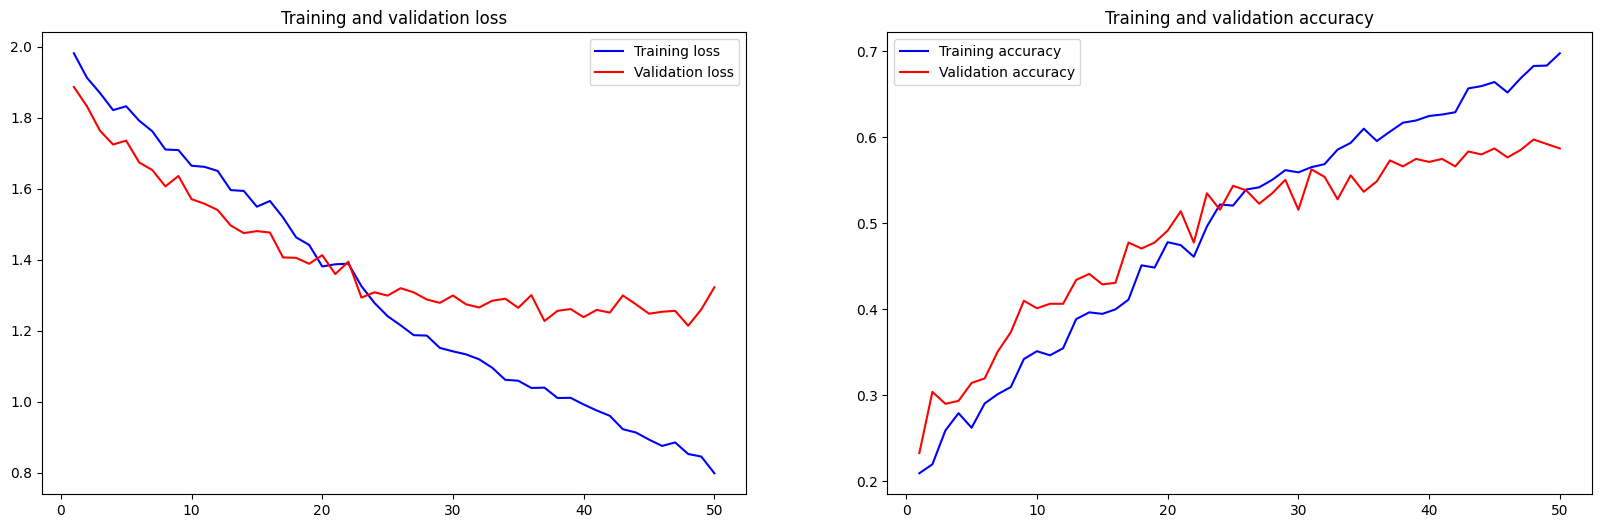

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


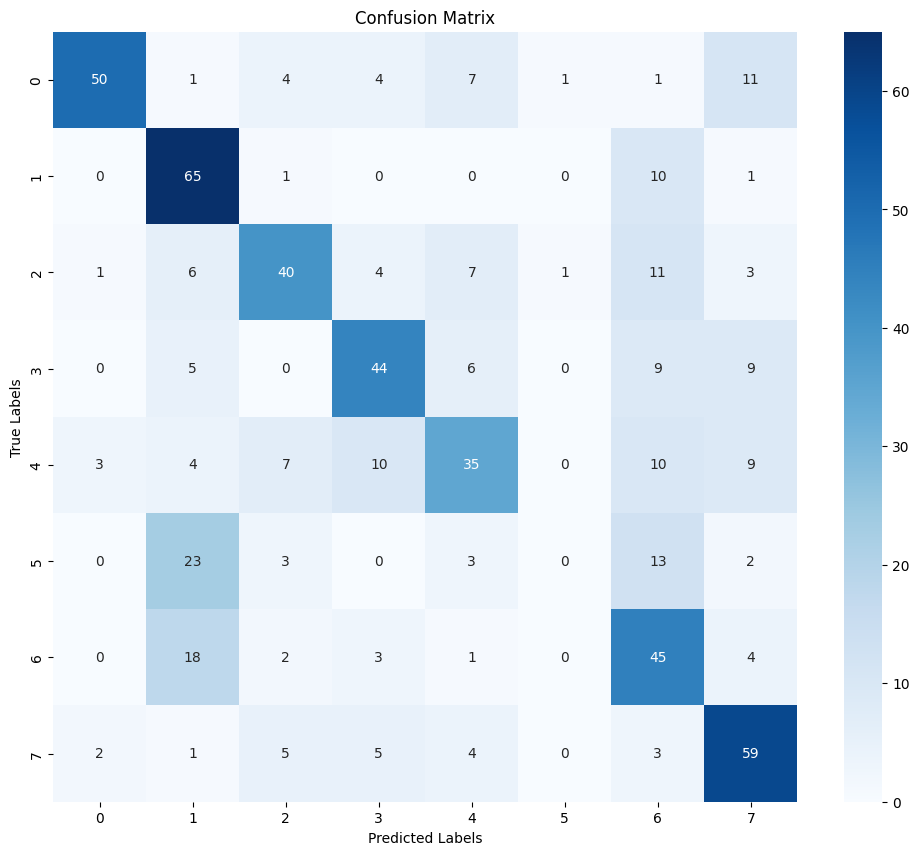

              precision    recall  f1-score   support

       angry       0.89      0.63      0.74        79
        calm       0.53      0.84      0.65        77
     disgust       0.65      0.55      0.59        73
        fear       0.63      0.60      0.62        73
       happy       0.56      0.45      0.50        78
     neutral       0.00      0.00      0.00        44
         sad       0.44      0.62      0.51        73
    surprise       0.60      0.75      0.67        79

    accuracy                           0.59       576
   macro avg       0.54      0.55      0.53       576
weighted avg       0.57      0.59      0.57       576



In [7]:
def extract_features(data, sr):
    result = np.array([])
    # ZCR: What
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    # Pass sample_rate to extract_features
    res1 = extract_features(data, sample_rate)
    result = np.array([res1])

    # With augmentation (simplified for this example)
    noise_data = data + 0.005 * np.random.randn(len(data))
    # Pass sample_rate to extract_features
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    return result

X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        Y.append(emotion)

X = np.array(X)
Y = np.array(Y)

# Data Preparation for model
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1)).toarray()

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for Conv1D layer
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Modelling
model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),
    Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Flatten(),
    Dense(units=32, activation='relu'),
    Dropout(0.3),
    Dense(units=Y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])

# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

# Visualization
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'b', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = encoder.inverse_transform(y_pred)
y_true = encoder.inverse_transform(y_test)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes))